In [ ]:
!pip install -q fasttext
!pip install -q sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 881.4 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 41.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import fasttext.util
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/STS Measures/scopus_data/combined.csv')
dataset.head()

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,Page count,DOI,Link,Abstract,Author Keywords,Index Keywords,Document Type,Source,EID
0,Viviano C.M.; Alderete M.R.; Boarts C.; McCart...,"Viviano, Carolyn M. (56297262200); Alderete, M...",56297262200; 56297775400; 56297651700; 5629818...,"Stop, look, listen: Making a difference in the...",2012,ACS Symposium Series,1121,NaN,NaN,111,131,20.0,10.1021/bk-2012-1121.ch008,https://www.scopus.com/inward/record.uri?eid=2...,We draw on our experiences designing and imple...,NaN,Curricula; Teaching; Collaborative partnership...,Conference paper,Scopus,2-s2.0-84905010091
1,Hosseini S.A.; Nosratabadi A.; Nehzati T.; Ism...,"Hosseini, Seyed Ali (57192005556); Nosratabadi...",57192005556; 55533525100; 36610504200; 5560648...,Trend in sustainability of facility design and...,2012,Applied Mechanics and Materials,229-231,NaN,NaN,2562,2566,4.0,10.4028/www.scientific.net/AMM.229-231.2562,https://www.scopus.com/inward/record.uri?eid=2...,The sustainability concept today is at the fro...,Manufacturing; Sustainable facility design; Su...,Design; Planning; Production control; Producti...,Conference paper,Scopus,2-s2.0-84871373629
2,Kwon H.-I.; Joo H.-Y.; Kim D.-J.; Park J.-S.,"Kwon, Hyeog-In (55376528000); Joo, Hi-Yeob (55...",55376528000; 55375519400; 51261070000; 5553832...,The development of sustainable growth strategy...,2012,Lecture Notes in Computer Science (including s...,7513 LNCS,NaN,NaN,315,319,4.0,10.1007/978-3-642-35606-3_37,https://www.scopus.com/inward/record.uri?eid=2...,Currently the online game market continues gro...,MMORPG; On-line game; PLC; PLM; Sustainable gr...,Commerce; Parallel architectures; Programmable...,Conference paper,Scopus,2-s2.0-84871584006
3,Wu C.; He X.,"Wu, Chentao (25928165600); He, Xubin (23396475...",25928165600; 23396475000,GSR: A global stripe-based redistribution appr...,2012,Proceedings of the International Conference on...,NaN,NaN,6337607,460,469,9.0,10.1109/ICPP.2012.32,https://www.scopus.com/inward/record.uri?eid=2...,Under the severe energy crisis and the fast de...,RAID-5; Reliability; Scalability; Scaling,Energy policy; Metadata; Reliability; Sustaina...,Conference paper,Scopus,2-s2.0-84871125247
4,Razavi H.S.N.,"Razavi, H. Sadat Nabavi (57523839500)",57523839500,The critical role of open space in hazard miti...,2012,WIT Transactions on Information and Communicat...,44,NaN,NaN,437,448,11.0,10.2495/RISK120371,https://www.scopus.com/inward/record.uri?eid=2...,"Disasters, whether caused by humans or nature,...",Hazard mitigation; Historical cities; Open spa...,Disasters; Earthquakes; Essential component; H...,Conference paper,Scopus,2-s2.0-84871254377


In [ ]:
# pick data by list of 'Year'
years = [2022, 2023, 2024]
dataset = dataset[dataset['Year'].isin(years)]

# Sort data by 'Year'
dataset = dataset.sort_values(by='Year')

In [ ]:
dataset.shape

(120513, 20)

In [ ]:
# Find records where abstract is missing
missing_abstract = dataset[dataset['Abstract'].isnull()]
missing_abstract

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,Page count,DOI,Link,Abstract,Author Keywords,Index Keywords,Document Type,Source,EID


<Axes: xlabel='Year'>

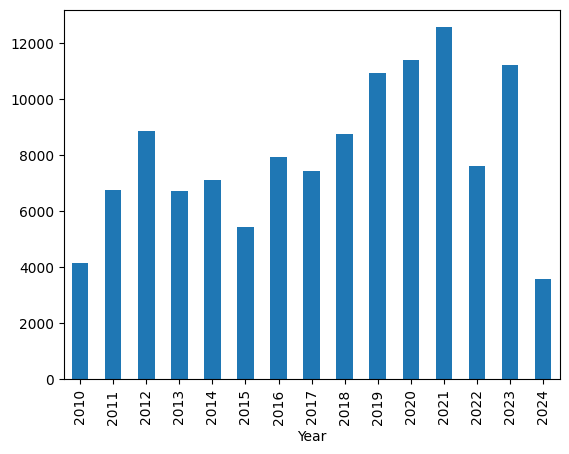

In [ ]:
# Plot data distribution by year
dataset['Year'].value_counts().sort_index().plot(kind='bar')

In [ ]:
print('Word-wise:')
dataset['Abstract Length in Words'] = dataset['Abstract'].apply(lambda x: len(str(x).split()))
print(dataset['Abstract Length in Words'].describe())

print('\nCharacter-wise:')
dataset['Abstract Length in Characters'] = dataset['Abstract'].apply(lambda x: len(str(x)))
print(dataset['Abstract Length in Characters'].describe())

Word-wise:
count    120513.000000
mean        188.762026
std          79.389429
min           3.000000
25%         136.000000
50%         177.000000
75%         228.000000
max        1589.000000
Name: Abstract Length in Words, dtype: float64

Character-wise:
count    120513.000000
mean       1277.407334
std         534.874659
min          23.000000
25%         924.000000
50%        1200.000000
75%        1537.000000
max       11495.000000
Name: Abstract Length in Characters, dtype: float64


In [ ]:
def cos_sim(v1, v2):
    mag1 = np.linalg.norm(v1)
    mag2 = np.linalg.norm(v2)
    if (not mag1) or (not mag2):
        return 0
    return np.dot(v1, v2) / (mag1 * mag2)

In [ ]:
# dataset = dataset[:1000]
abstracts = dataset['Abstract'].tolist()

# Summarization

In [ ]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# Load Pegasus model and tokenizer on gpu
model_name = 'google/pegasus-xsum'  # or 'google/pegasus-cnn_dailymail'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# Function to summarize text
def summarize_text(text):
    inputs = tokenizer(text, truncation=True, padding='longest', return_tensors="pt")
    summary_ids = model.generate(inputs.input_ids, num_beams=4, max_length=60, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Summarize abstracts
dataset['Summary'] = dataset['Abstract'].apply(summarize_text)

# Universal Sentence Encoder (USE)

In [ ]:
# Load the USE model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
use_embeddings = use_model(abstracts)

In [ ]:
use_similarity_matrix = cosine_similarity(use_embeddings)
print("USE Similarity Score between first two abstracts:", use_similarity_matrix[0, 1])

USE Similarity Score between first two abstracts: 0.4390471


In [ ]:
def get_use_query_embedding(query):
    return use_model([query]).numpy()

# SentenceTransformers (BERT)



In [ ]:
# Load the Sentence-BERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Generate embeddings
sbert_embeddings = sbert_model.encode(abstracts, convert_to_tensor=True, device=device)
sbert_embeddings = sbert_embeddings.cpu().numpy()

In [ ]:
sbert_similarity_matrix = cosine_similarity(sbert_embeddings)

In [ ]:
print("SBERT Similarity Score between first two abstracts:", sbert_similarity_matrix[0, 1])

SBERT Similarity Score between first two abstracts: 0.38722715


In [ ]:
def get_sbert_query_embedding(query):
    query_embedding = sbert_model.encode([query], convert_to_tensor=True, device=device)
    return query_embedding.cpu().numpy()

# FastText

In [ ]:
# fasttext.util.download_model('en', if_exists='ignore')  # English
fasttext_model = fasttext.load_model('/content/drive/MyDrive/STS Measures/cc.en.300.bin')



> Averaging based embedding



In [ ]:
def get_fasttext_embedding(text):
    words = text.split()
    word_vecs = [fasttext_model.get_word_vector(word) for word in words]
    return sum(word_vecs) / len(word_vecs)

In [ ]:
print("Generating FastText embeddings...")
fasttext_embeddings = [get_fasttext_embedding(abstract) for abstract in abstracts]

Generating FastText embeddings...


In [ ]:
def get_fasttext_query_embedding(query):
    return get_fasttext_embedding(query).reshape(1, -1)

# GloVe

In [ ]:
# Load GloVe embeddings
def load_glove_model(glove_file):
    print("Loading GloVe model...")
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
    print("GloVe model loaded.")
    return glove_model

glove_model = load_glove_model('/content/drive/MyDrive/STS Measures/glove.6B.300d.txt')

In [ ]:
def get_glove_embedding(text, glove_model):
    words = text.split()
    word_vecs = [glove_model[word] for word in words if word in glove_model]
    if len(word_vecs) == 0:  # handle cases where none of the words are in the GloVe model
        return np.zeros(300)
    return np.mean(word_vecs, axis=0)

print("Generating GloVe embeddings...")
glove_embeddings = [get_glove_embedding(abstract, glove_model) for abstract in abstracts]

In [ ]:
def get_glove_query_embedding(query):
    return get_glove_embedding(query, glove_model).reshape(1, -1)

# ELMo

In [ ]:
print("Loading ELMo model...")
elmo_model = hub.load("https://tfhub.dev/google/elmo/3")

Loading ELMo model...


In [ ]:
def get_elmo_embeddings(texts):
    elmo_embeddings = []
    for text in texts:
        elmo_output = elmo_model.signatures['default'](tf.constant([text]))['elmo']
        elmo_embedding = tf.reduce_mean(elmo_output, axis=1).numpy()
        elmo_embeddings.append(elmo_embedding)
    return np.array(elmo_embeddings).reshape(len(texts), -1)

In [ ]:
print("Generating ELMo embeddings...")
elmo_embeddings = get_elmo_embeddings(abstracts)

Generating ELMo embeddings...


In [ ]:
def get_elmo_query_embedding(query):
    return get_elmo_embeddings([query]).reshape(1, -1)

# Testing Section

In [ ]:
def get_top_n_similar_abstracts(query_embedding, abstract_embeddings, top_n=5):
    # Compute cosine similarity
    similarity_scores = cosine_similarity(query_embedding, abstract_embeddings).flatten()
    # Get the top N most similar abstracts
    top_n_indices = similarity_scores.argsort()[-top_n:][::-1]
    return top_n_indices, similarity_scores[top_n_indices]

# Function to search abstracts
def search_abstracts(query, method='use', top_n=5):
    if method == 'use':
        query_embedding = get_use_query_embedding(query)
        abstract_embeddings = use_embeddings
    elif method == 'sbert':
        query_embedding = get_sbert_query_embedding(query)
        abstract_embeddings = sbert_embeddings
    elif method == 'fasttext':
        query_embedding = get_fasttext_query_embedding(query)
        abstract_embeddings = fasttext_embeddings
    elif method == 'glove':
        query_embedding = get_glove_query_embedding(query)
        abstract_embeddings = glove_embeddings
    elif method == 'elmo':
        query_embedding = get_elmo_query_embedding(query)
        abstract_embeddings = elmo_embeddings
    else:
        raise ValueError("Unknown method: choose 'use' or 'sbert'")

    top_n_indices, top_n_scores = get_top_n_similar_abstracts(query_embedding, abstract_embeddings, top_n)

    for i, idx in enumerate(top_n_indices):
        print(f"Rank {i+1}:")
        print(f"Abstract: {abstracts[idx]}")
        print(f"Similarity Score: {top_n_scores[i]}")
        print()

USE test

In [ ]:
query = "sustainable developement"
search_abstracts(query, method='use', top_n=5)

Rank 1:
Abstract: The sustainability concept today is at the front lines of new technologies in manufacturing, products and work methodology. Be a sustainable manufacturer is critical issue to the future of manufacturing system. Various efforts have been conducted around the world to ensure the sustainability of manufacturing system. This study addresses current trend in sustainable manufacturing by focus on two major elements, which are facility design and production planning. Critical challenges are listed and future trends have been discussed. © (2012) Trans Tech Publications, Switzerland.
Similarity Score: 0.22926534712314606

Rank 2:
Abstract: We draw on our experiences designing and implementing a SENCER course for future science teachers to discuss the benefits of an integrated and relevant community-based learning experience for future educators. Broad issues related to water and the environment form the core of our capstone course; students collaborate with environmental educa

SentenceTransformers

In [ ]:
query = "sustainable developement"
search_abstracts(query, method='sbert', top_n=5)

Rank 1:
Abstract: The sustainability concept today is at the front lines of new technologies in manufacturing, products and work methodology. Be a sustainable manufacturer is critical issue to the future of manufacturing system. Various efforts have been conducted around the world to ensure the sustainability of manufacturing system. This study addresses current trend in sustainable manufacturing by focus on two major elements, which are facility design and production planning. Critical challenges are listed and future trends have been discussed. © (2012) Trans Tech Publications, Switzerland.
Similarity Score: 0.6758826971054077

Rank 2:
Abstract: Air transportation and manageable cost is the key to determine the smooth running of the airlines. Today, the trend is changing with the environment generally and sustainability standards specifically. Responsibility towards environmental issues, in conjunction with safety and security, remains an essential promise for the aviation industry, 

FastText test

In [ ]:
query = "sustainable developement"
search_abstracts(query, method='fasttext', top_n=5)

Rank 1:
Abstract: Air transportation and manageable cost is the key to determine the smooth running of the airlines. Today, the trend is changing with the environment generally and sustainability standards specifically. Responsibility towards environmental issues, in conjunction with safety and security, remains an essential promise for the aviation industry, even in the face of the economic downturn. IATA's vision is for carbon-neutral growth on the way to a zero-emission future. This is being implemented through IATA's four-pillar strategy: investing in technology, flying planes effectively, building efficient infrastructure and using positive economic measures (technology, operations, infrastructure and economic instruments). This paper will focus in the projection on biofuel as an alternative energy compromise reduction in carbon dioxide (CO2) emission in overview through short-term and long-term feedstock biomass. As environmental concerns are becoming clearer in general transport

ELMo test

In [ ]:
query = "sustainable developement"
search_abstracts(query, method='elmo', top_n=5)

Rank 1:
Abstract: The sustainability concept today is at the front lines of new technologies in manufacturing, products and work methodology. Be a sustainable manufacturer is critical issue to the future of manufacturing system. Various efforts have been conducted around the world to ensure the sustainability of manufacturing system. This study addresses current trend in sustainable manufacturing by focus on two major elements, which are facility design and production planning. Critical challenges are listed and future trends have been discussed. © (2012) Trans Tech Publications, Switzerland.
Similarity Score: 0.5775701999664307

Rank 2:
Abstract: Air transportation and manageable cost is the key to determine the smooth running of the airlines. Today, the trend is changing with the environment generally and sustainability standards specifically. Responsibility towards environmental issues, in conjunction with safety and security, remains an essential promise for the aviation industry, 

# Experimental Section

> Text Pre-processing



In [ ]:
exit(0)

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def remove_stopwords(stop_words, tokens):
    res = []
    for token in tokens:
        if not token in stop_words:
            res.append(token)
    return res

def process_text(text):
    text = text.encode('ascii', errors='ignore').decode()
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'#+', ' ', text )
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"([A-Za-z]+)'s", r"\1 is", text)
    #text = re.sub(r"\'s", " ", text)     text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"won't", "will not ", text)
    text = re.sub(r"isn't", "is not ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    return text

def lemmatize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_list = []
    for token in tokens:
        lemma = lemmatizer.lemmatize(token, 'v')
        if lemma == token:
            lemma = lemmatizer.lemmatize(token)
        lemma_list.append(lemma)
    # return [ lemmatizer.lemmatize(token, 'v') for token in tokens ]     return lemma_list


def process_all(text):
    text = process_text(text)
    return ' '.join(remove_stopwords(stop_words, text.split()))